In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# For colab users
path = '/content/drive/MyDrive/Classroom/2022년 KDB-SNU AI 비학위과정/과제_Bitcoin/'
#path = '/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
filename = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
df_raw = pd.read_csv(f'{path}{filename}')

In [ ]:
# warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import datetime, pytz
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
import keras
import tensorflow

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [ ]:
df_raw.shape[1]

8

In [ ]:
df_raw['date'] = pd.to_datetime(df_raw['Timestamp'],unit='s').dt.date
df_group = df_raw.groupby('date')
Price = df_group['Close'].mean()

date
2011-12-31        4.482500
2012-01-01        4.806667
2012-01-02        5.000000
2012-01-03        5.252500
2012-01-04        5.223333
                  ...     
2021-03-27    55195.415367
2021-03-28    55835.012863
2021-03-29    56915.629993
2021-03-30    58349.357087
2021-03-31    58778.180000
Name: Close, Length: 3376, dtype: float64

In [ ]:
Price.shape

(3376,)

In [ ]:
df_raw.shape

(4857377, 9)

findfont: Font family ['malgun'] not found. Falling back to DejaVu Sans.
findfont: Font family ['malgun'] not found. Falling back to DejaVu Sans.


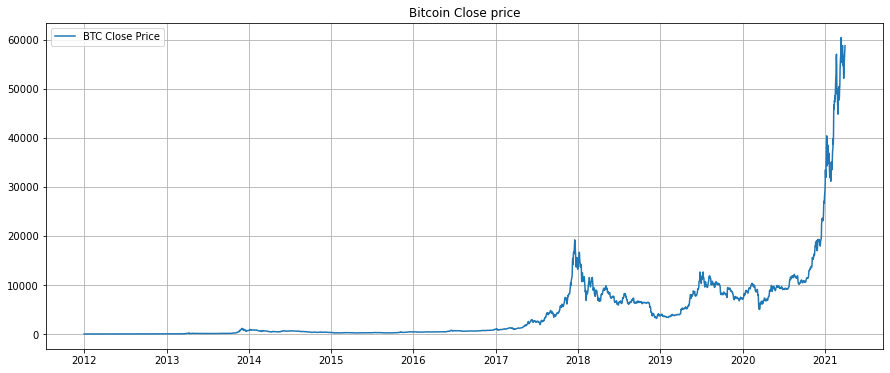

In [ ]:
plt.figure(figsize = (15,6))
# plt.plot(df.index, df['Close'], label = 'Close price')
plt.plot(Price, label = 'BTC Close Price')
plt.legend()
plt.grid()
plt.title('Bitcoin Close price')
plt.savefig('./bitcoin_close_price.png')
plt.show()

In [ ]:
df_price_zz=Price.to_frame()
df_price_zz['Timestamp'] = df_price_zz.index
df_price_zz['Timestamp'] = pd.to_datetime(df_price_zz['Timestamp'])
df_price_zz.reset_index(drop=True,inplace=True)
df_price_include_zz = df_price_zz[df_price_zz['Timestamp'].dt.year >= 2017]
df_price_include_zz.reset_index(drop=True,inplace=True)

In [ ]:
df_price_include_zz = df_price_include_zz[['Timestamp','Close']]

In [ ]:
df_price_include_zz.head()

,Timestamp,Close
0,2017-01-01,981.657848
1,2017-01-02,1013.255191
2,2017-01-03,1020.044834
3,2017-01-04,1079.599514
4,2017-01-05,1039.794196


In [ ]:
df_price_include_zz.set_index("Timestamp", inplace = True)
df_price_include_zz

,Close
Timestamp,
2017-01-01,981.657848
2017-01-02,1013.255191
2017-01-03,1020.044834
2017-01-04,1079.599514
2017-01-05,1039.794196
...,...
2021-03-27,55195.415367
2021-03-28,55835.012863
2021-03-29,56915.629993


In [ ]:
df_price_include_zz.shape[0]

1551

In [ ]:
Price.to_numpy()
df_price=Price.to_frame()
df_price['Timestamp'] = df_price.index
df_price['Timestamp'] = pd.to_datetime(df_price['Timestamp'])
df_price.reset_index(drop=True,inplace=True)
df_price_include = df_price[df_price['Timestamp'].dt.year >= 2017]
df_price_include.reset_index(drop=True,inplace=True)

In [ ]:
prediction_days = 50
df_train= df_price_include_zz[:len(df_price_include_zz)-prediction_days] #마지막 50일치 빼고 훈련 데이터로 세팅
df_test= df_price_include_zz[len(df_price_include_zz)-prediction_days:] #마지막 50일치를 Test Set으로 설정
df_train.tail(5)

,Close
Timestamp,
2021-02-05,37631.477830
2021-02-06,39815.101279
2021-02-07,38713.952774
2021-02-08,41199.296210
2021-02-09,46685.854139


In [ ]:
df_test.tail(5)

,Close
Timestamp,
2021-03-27,55195.415367
2021-03-28,55835.012863
2021-03-29,56915.629993
2021-03-30,58349.357087
2021-03-31,58778.180000


In [ ]:
df_test.head(5)

,Close
Timestamp,
2021-02-10,45801.332042
2021-02-11,46275.117958
2021-02-12,47605.611299
2021-02-13,47276.645177
2021-02-14,48602.309979


# XGBoost(Qoo)

In [ ]:
from xgboost import XGBRegressor
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from itertools import cycle
import plotly.express as px

In [ ]:
df_price_zz_all=Price.to_frame()
df_price_zz_all['Timestamp'] = df_price_zz_all.index
df_price_zz_all['Timestamp'] = pd.to_datetime(df_price_zz_all['Timestamp'])
df_price_zz_all.reset_index(drop=True,inplace=True)
df_price_include_xg = df_price_zz_all[df_price_zz_all['Timestamp'].dt.year >= 2017]
df_price_include_xg.reset_index(drop=True,inplace=True)
closedf = df_price_include_xg[['Timestamp','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1551, 2)


In [ ]:
closedf.head()

,Timestamp,Close
0,2017-01-01,981.657848
1,2017-01-02,1013.255191
2,2017-01-03,1020.044834
3,2017-01-04,1079.599514
4,2017-01-05,1039.794196


In [ ]:
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  1551


In [ ]:
#Normalizing close price value
del closedf['Timestamp']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1551, 1)


In [ ]:
test_size=int(len(closedf)*0.15)
training_size=len(closedf)-test_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1319, 1)
test_data:  (232, 1)


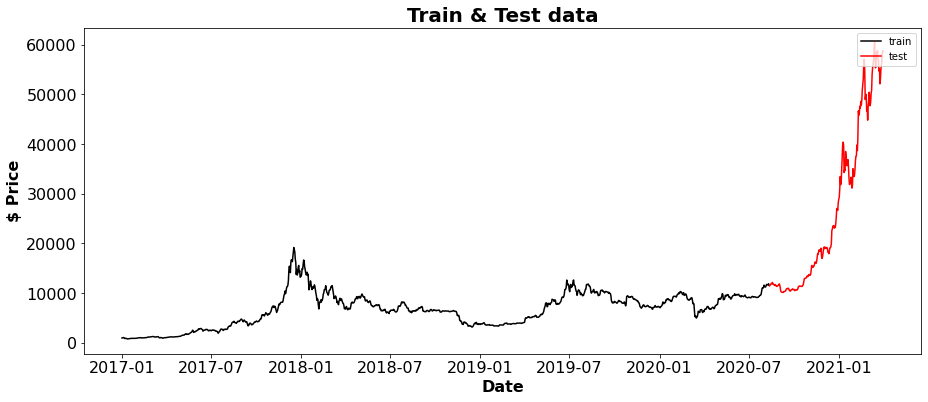

In [ ]:

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['Timestamp'][:len(train_data)], y = close_stock['Close'][:len(train_data)], color = 'black')
sns.lineplot(x = close_stock['Timestamp'][len(train_data):], y = close_stock['Close'][len(train_data):], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('$ Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1268, 50)
y_train:  (1268,)
X_test:  (181, 50)
y_test (181,)


In [ ]:
# Biulding Model
# Import XGBRegressor module and Fit X_train and y_train for training model

model5 = XGBRegressor(n_estimators=1000)
model5.fit(X_train, y_train, verbose=False)

[03:51:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [ ]:

predictions = model5.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.26032790306808967
Root Mean squared Error - RMSE : 0.3641143730838047


In [ ]:
train_predict=model5.predict(X_train)
test_predict=model5.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1268, 1)
Test data prediction: (181, 1)


In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['Timestamp'],
                       'Original_Price': close_stock['Close'],
                      'Train_predicted_Price': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'Test_predicted_Price': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['Original_Price'],plotdf['Train_predicted_Price'],
                                          plotdf['Test_predicted_Price']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1551, 1)
Test predicted data:  (1551, 1)


# LSTM(Dataset 준비)

In [ ]:
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [ ]:
len(training_set2)

1501

In [ ]:
len(X_train)

1500

# LinearRegression(Qoo)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime

In [ ]:
df_raw.dropna(inplace=True)

In [ ]:
df_raw['Timestamp'] = [datetime.fromtimestamp(x) for x in df_raw['Timestamp']]

In [ ]:
df_raw = df_raw.set_index('Timestamp')

In [ ]:
df_raw = df_raw.resample("24H").mean()
df_raw.head()

In [ ]:
df_raw = df_raw.reset_index()

In [ ]:
df_raw.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
1,2012-01-01,4.806667,4.806667,4.806667,4.806667,7.200667,35.259720,4.806667
2,2012-01-02,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000
3,2012-01-03,5.252500,5.252500,5.252500,5.252500,11.004660,58.100651,5.252500
4,2012-01-04,5.200000,5.223333,5.200000,5.223333,11.914807,63.119577,5.208159


In [ ]:
#df_raw['Timestamp'] = df_raw[['Timestamp']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)

In [ ]:
#df_raw = df_raw.drop('level_0', axis=1)

In [ ]:
#df_raw = df_raw.drop('index', axis=1)

In [ ]:
df_raw.head()

In [ ]:
df_raw.info()

In [ ]:
required_features = ['Open', 'High', 'Low', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']
output_label = 'Close'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
df_raw[required_features],
df_raw[output_label],
test_size = 0.3
)

In [ ]:
model4 = LinearRegression()

In [ ]:
model4.fit(X_train, y_train)

LinearRegression()

In [ ]:
model4.score(X_test, y_test)

0.9999999975929826

In [ ]:
#Prediction the Prices
#create a future dataset by shifting the original data by 30 days
future_set = df_raw.shift(periods=30).tail(30)

In [ ]:
#predict the prices for the future_set we just created.
prediction = model4.predict(future_set[required_features])

Text(0, 0.5, '$ Price')

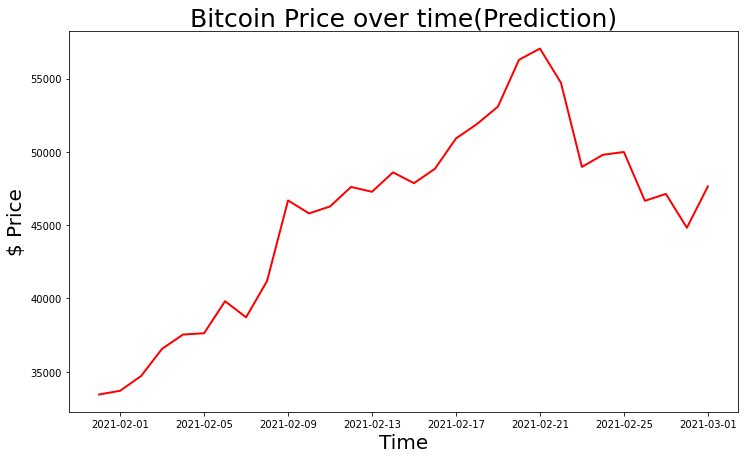

In [ ]:
#plot a graph showing the previous Bitcoin (in yellow color) prices and our predicted prices (in pink color).
plt.figure(figsize = (12, 7))
#plt.plot(df_raw["Timestamp"][-400:-60], df_raw["Weighted_Price"][-400:-60], color='goldenrod', lw=2)
plt.plot(future_set["Timestamp"], prediction, color='red', lw=2)
#plt.plot2(df_raw["Timestamp"][-60:], df_raw["Weighted_Price"][-60:], color='goldenrod', lw=2)
plt.title("Bitcoin Price over time(Prediction)", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)

Text(0, 0.5, '$ Price')

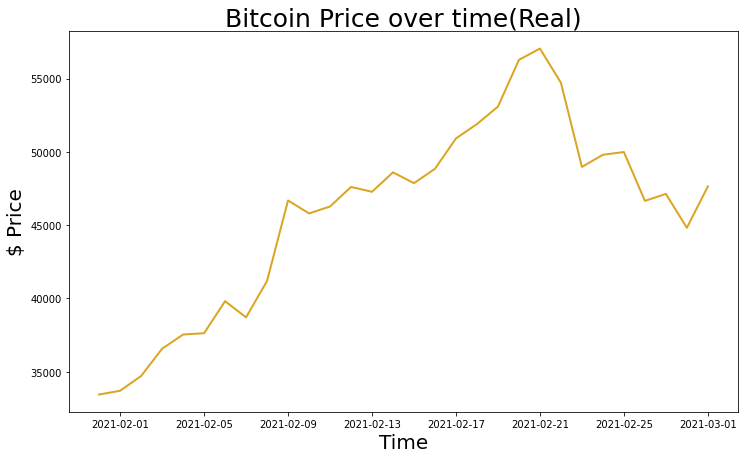

In [ ]:
#plot a graph showing the previous Bitcoin (in yellow color) prices and our predicted prices (in pink color).
plt.figure(figsize = (12, 7))
#plt.plot(df_raw["Timestamp"][-400:-60], df_raw["Weighted_Price"][-400:-60], color='goldenrod', lw=2)
#plt.plot(future_set["Timestamp"], prediction, color='red', lw=2)
plt.plot(df_raw["Timestamp"][-60:-30], df_raw["Weighted_Price"][-60:-30], color='goldenrod', lw=2)
plt.title("Bitcoin Price over time(Real)", size=25)
plt.xlabel("Time", size=20)
plt.ylabel("$ Price", size=20)

# CNN(Dataset 준비)

In [ ]:
training_set2 = df_train.values
#training_set2 = np.reshape(training_set2, (len(training_set2), 1))

In [ ]:
training_set2 = sc.fit_transform(training_set2)

In [ ]:
X_train_cnn = training_set2[0:len(training_set2)-1]

In [ ]:
y_train_cnn = training_set2[1:len(training_set2)]

In [ ]:
X_train_cnn = np.reshape(X_train_cnn, (len(X_train_cnn), 1))

In [ ]:
y_train_cnn = np.reshape(y_train_cnn, (len(y_train_cnn), 1))

In [ ]:
#validation Set 추가 구성
training_size = int(len(X_train_cnn)*0.8)

X_train_cnn = X_train_cnn[:training_size]
y_train_cnn = y_train_cnn[:training_size]

X_val_cnn = X_train_cnn[training_size:]
y_val_cnn = y_train_cnn[training_size:]

In [ ]:
#CNN

from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU

model3 = Sequential()
model3.add(Conv1D(activation='relu', input_shape=(None, 1), strides=3, filters=8, kernel_size=20))
model3.add(Dropout(0.2))
model3.add(Conv1D( strides=4, filters=1, kernel_size=16))

'''
# 3 Layers
model3.add(Conv1D(activation='relu', input_shape=(None, 1), strides=3, filters=8, kernel_size=8))
model3.add(Dropout(0.2))
model3.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=8))
model3.add(Dropout(0.2))
model3.add(Conv1D( strides=2, filters=1, kernel_size=8))

# 4 layers
model3.add(Conv1D(activation='relu', input_shape=(None, 1), strides=2, filters=8, kernel_size=2))
model3.add(Dropout(0.2))
model3.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
model3.add(Dropout(0.2))
model3.add(Conv1D(activation='relu', strides=2, filters=8, kernel_size=2))
model3.add(Dropout(0.2))
model3.add(Conv1D( strides=2, filters=1, kernel_size=2))
'''

model3.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 8)           168       
                                                                 
 dropout (Dropout)           (None, None, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 1)           129       
                                                                 
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history3=model3.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), batch_size = 5, epochs = 20)

ValueError: Error when checking input: expected conv1d_7_input to have 3 dimensions, but got array with shape (614, 1)

# SimpleRNN(Qoo)

In [ ]:
#Simple RNN

from keras.layers import SimpleRNN

model2 = Sequential()
model2.add(SimpleRNN(128, activation='relu', return_sequences = True, input_shape = (None, 1)))
model2.add(Dropout(0)) 
model2.add(SimpleRNN(256, return_sequences=True, activation="relu"))
model2.add(Dropout(0)) 
model2.add(SimpleRNN(128, return_sequences=True, activation="relu"))
model2.add(Dropout(0)) 
model2.add(SimpleRNN(64, return_sequences=True, activation="relu"))
model2.add(Dropout(0)) 
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model2.summary()

In [ ]:
history2=model2.fit(X_train, y_train, batch_size = 5, epochs = 20)

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,5))
plt.plot(history2.history['loss'])
plt.title("The model's evaluation(SimpleRNN)", fontsize=14)
plt.xlabel('The num of Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=False)

In [ ]:
# Making the predictions
test_set2 = df_test.values
inputs2 = np.reshape(test_set2, (len(test_set2), 1))
inputs2 = sc.transform(inputs2)
inputs2 = np.reshape(inputs2, (len(inputs2), 1, 1))
predicted_BTC_price2 = model2.predict(inputs2)
predicted_BTC_price2 = predicted_BTC_price2.reshape(-1,1)
predicted_BTC_price2 = sc.inverse_transform(predicted_BTC_price2)

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.plot(test_set2, color = "red", label = "Real Stock Price")
plt.plot(predicted_BTC_price2, color = "black", label = "Predict Stock Price(SimpleRNN)")
plt.title("BTC Price Prediction")
plt.xlabel("Time")
plt.ylabel("BTC Price(USD)")
plt.legend()
plt.show()

# LSTM

In [ ]:
#LSTM

model1 = Sequential()
model1.add(LSTM(10, activation="sigmoid", return_sequences = True, input_shape = (None, 1)))
# model1.add(Dropout(0.2))
# model1.add(LSTM(64,return_sequences = True))
# model1.add(Dropout(0.2))
# model1.add(LSTM(10))
# model1.add(Dropout(0.2))

model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model1.summary()

In [ ]:
history=model1.fit(X_train, y_train, batch_size = 5, epochs = 20)

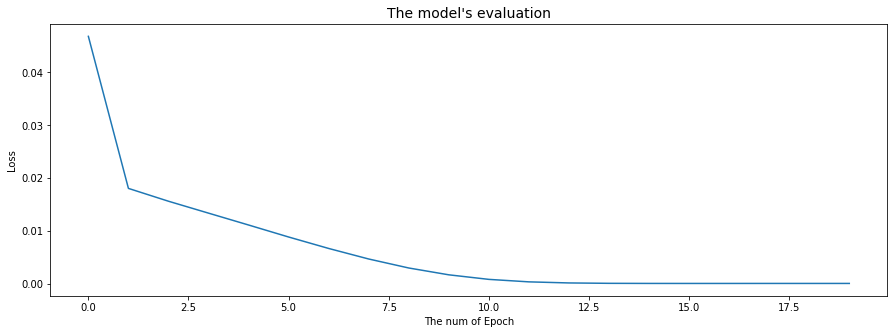

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.title("The model's evaluation", fontsize=14)
plt.xlabel('The num of Epoch')
plt.ylabel('Loss')
plt.show()

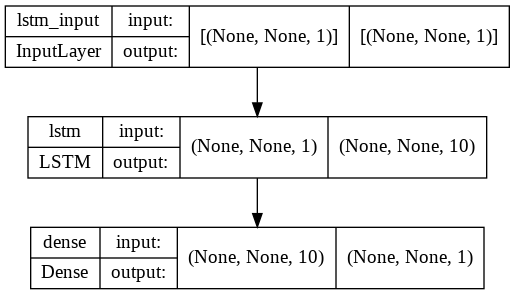

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=False)

In [ ]:
# Making the predictions
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model1.predict(inputs)
predicted_BTC_price=predicted_BTC_price.reshape(-1,1)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

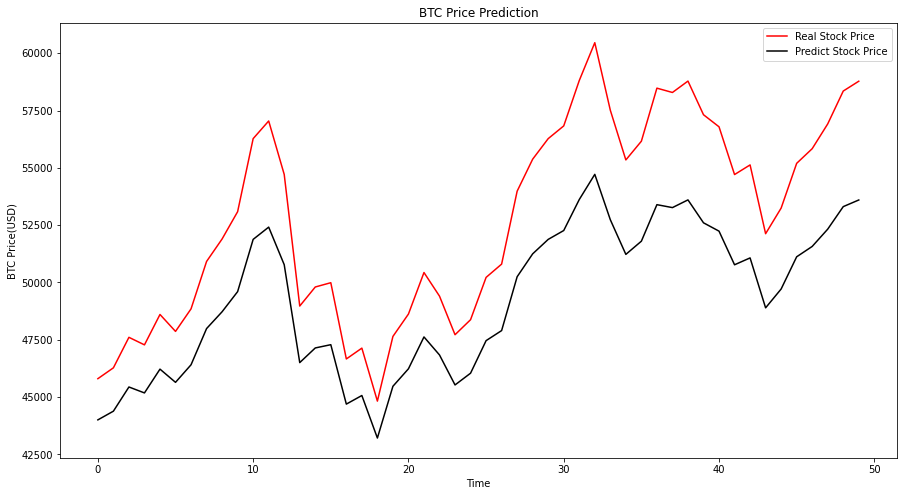

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.plot(test_set, color = "red", label = "Real Stock Price")
plt.plot(predicted_BTC_price, color = "black", label = "Predict Stock Price")
plt.title("BTC Price Prediction")
plt.xlabel("Time")
plt.ylabel("BTC Price(USD)")
plt.legend()
plt.show()

# 3. FEATURE ENGINEERING
> Much of the success of machine learning is actually success in
engineering features that a learner can understand.   
-- Scott Locklin, in "Neglected machine learning ideas"